In [1]:
import numpy as np
import scipy.optimize as opt
import sys
import astropy.io.fits as pyfits
import math
import matplotlib.pylab as plt
import pickle
import time
from scipy.interpolate import Rbf
import katcali.io as kio

In [2]:
print  (plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'])
plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 14, 1.5, 1.5
#plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 10.0, 0.8, 1.5
print  (plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'])


10.0 0.8 1.5
14.0 1.5 1.5


In [3]:
print ('start @ ' + time.asctime(time.localtime(time.time())) +'#')


start @ Thu Dec 26 15:59:13 2024#


In [4]:
def gauss_model(xi, yi, center_x, center_y, sigma):
    r2=(xi-center_x)**2.0+(yi-center_y)**2.0
    result= 1*np.exp(-r2/(2*sigma**2.0))
    return result

def func_obj(param, *args):
    sigma = param[0]
    center_x=param[1]
    center_y=param[2]
    xi=args[0]
    yi=args[1]
    data=args[2]
    
    model_value=gauss_model(xi, yi, center_x, center_y, sigma)
    result= np.sum((model_value-data)**2)
    #print(sigma, result)
    return result

In [5]:
#d=np.load('MeerKAT_U_band_primary_beam.npz')
d=np.load('MeerKAT_U_band_primary_beam_aa_highres.npz')

In [6]:
d.keys()

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f3428ad6048>)

In [7]:
print (d['pols'])

[b'HH' b'HV' b'VH' b'VV']


In [8]:
print (d['antnames'])

[b'array_average']


In [9]:
freqs_MHz=(d['freq_MHz'])
print (len(freqs_MHz))

1024


In [10]:
margin_deg=d['margin_deg']
print (np.shape(margin_deg))
print (margin_deg)

(512,)
[-6.        -5.9765625 -5.953125  -5.9296875 -5.90625   -5.8828125
 -5.859375  -5.8359375 -5.8125    -5.7890625 -5.765625  -5.7421875
 -5.71875   -5.6953125 -5.671875  -5.6484375 -5.625     -5.6015625
 -5.578125  -5.5546875 -5.53125   -5.5078125 -5.484375  -5.4609375
 -5.4375    -5.4140625 -5.390625  -5.3671875 -5.34375   -5.3203125
 -5.296875  -5.2734375 -5.25      -5.2265625 -5.203125  -5.1796875
 -5.15625   -5.1328125 -5.109375  -5.0859375 -5.0625    -5.0390625
 -5.015625  -4.9921875 -4.96875   -4.9453125 -4.921875  -4.8984375
 -4.875     -4.8515625 -4.828125  -4.8046875 -4.78125   -4.7578125
 -4.734375  -4.7109375 -4.6875    -4.6640625 -4.640625  -4.6171875
 -4.59375   -4.5703125 -4.546875  -4.5234375 -4.5       -4.4765625
 -4.453125  -4.4296875 -4.40625   -4.3828125 -4.359375  -4.3359375
 -4.3125    -4.2890625 -4.265625  -4.2421875 -4.21875   -4.1953125
 -4.171875  -4.1484375 -4.125     -4.1015625 -4.078125  -4.0546875
 -4.03125   -4.0078125 -3.984375  -3.9609375 -3.9375   

# margin_deg is shifted by half a pixel, don't use it!

In [11]:
#12/128
12/512

0.0234375

In [12]:
#(margin_deg[-1]-margin_deg[0])/127
(margin_deg[-1]-margin_deg[0])/511

0.0234375

In [13]:
print (np.shape(d['beam']))

(4, 1, 1024, 512, 512)


In [14]:
#beam_ave=d['beam'][:,-1,:,:,:] #use the array_average
beam_ave=d['beam'][:,0,:,:,:]

In [15]:
print (np.shape(beam_ave))

(4, 1024, 512, 512)


In [16]:
Npix=np.shape(beam_ave)[-1]
print (Npix)

512


In [17]:
grid_i=902 #local channel index
freq_local=freqs_MHz[grid_i]
print (freq_local)

1023.1875


In [18]:
print (beam_ave[0,grid_i,:,:])

[[-0.00036269+1.23580554e-04j -0.00040299+1.52976514e-04j
  -0.0004421 +1.80704068e-04j ... -0.00018043+1.02573933e-04j
  -0.00015525+8.32442456e-05j -0.00012981+6.30273935e-05j]
 [-0.00037629+1.16076022e-04j -0.00041563+1.45398968e-04j
  -0.00045366+1.73014094e-04j ... -0.00016391+9.16167992e-05j
  -0.00014098+7.33515408e-05j -0.00011772+5.41754889e-05j]
 [-0.00038833+1.08913926e-04j -0.00042639+1.38060117e-04j
  -0.00046311+1.65484875e-04j ... -0.0001451 +7.99802583e-05j
  -0.00012464+6.28579292e-05j -0.00010378+4.48039973e-05j]
 ...
 [-0.00031616-4.30100372e-05j -0.00029155-6.06477734e-05j
  -0.00026606-7.86346718e-05j ... -0.00013045-4.44818812e-04j
  -0.00014507-4.37616516e-04j -0.00015898-4.30264306e-04j]
 [-0.00033864-1.40872744e-05j -0.00031457-3.20898325e-05j
  -0.00028968-5.05073585e-05j ... -0.00014732-4.51160566e-04j
  -0.00016084-4.43206460e-04j -0.00017355-4.35077120e-04j]
 [-0.00035899+1.47559331e-05j -0.00033562-3.45243166e-06j
  -0.00031134-2.21265200e-05j ... -0.00016

In [19]:
print (d['pols'])

[b'HH' b'HV' b'VH' b'VV']


In [20]:
img_HH=abs(beam_ave[0,grid_i,:,:])**2 #squared!!!
img_HV=abs(beam_ave[1,grid_i,:,:])**2
img_VH=abs(beam_ave[2,grid_i,:,:])**2
img_VV=abs(beam_ave[3,grid_i,:,:])**2
print (img_HH.max(),img_VV.max())
img_HH=img_HH/img_HH.max()
img_VV=img_VV/img_VV.max()
print (img_HH.max(),img_VV.max())

0.99997175 1.0000031
1.0 1.0


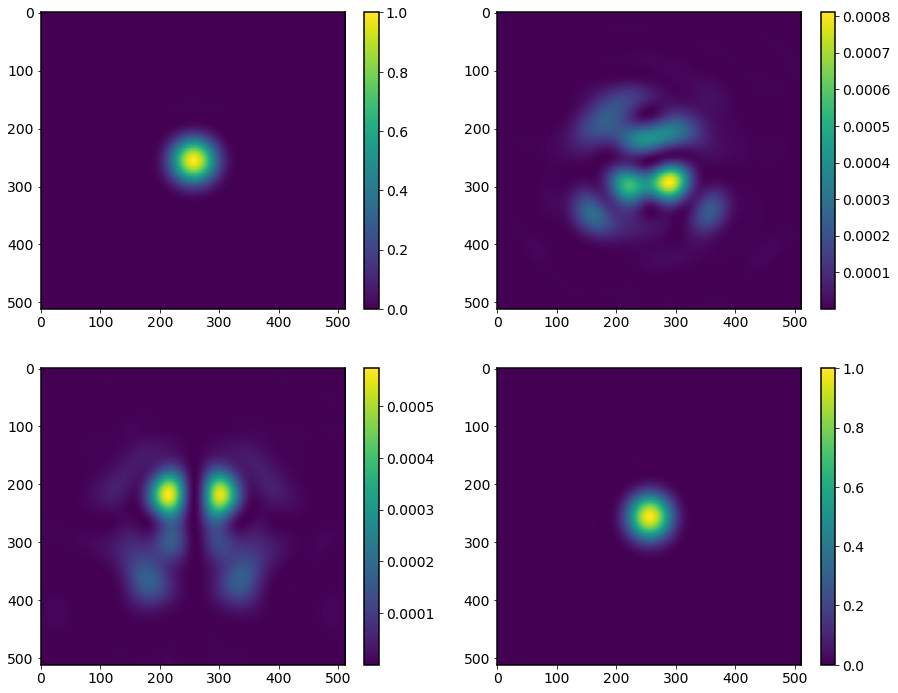

In [21]:
plt.figure(figsize = (15,12))
plt.subplot(221)
plt.imshow(img_HH,aspect='auto')
plt.colorbar()
plt.subplot(222)
plt.imshow(img_HV,aspect='auto')
plt.colorbar()
plt.subplot(223)
plt.imshow(img_VH,aspect='auto')
plt.colorbar()
plt.subplot(224)
plt.imshow(img_VV,aspect='auto')
plt.colorbar()
plt.show()

In [22]:
print (margin_deg[0],margin_deg[-1])

-6.0 5.9765625


In [23]:
pix_ticks=[0,128,256,384,512]

/usr/lib/python3/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


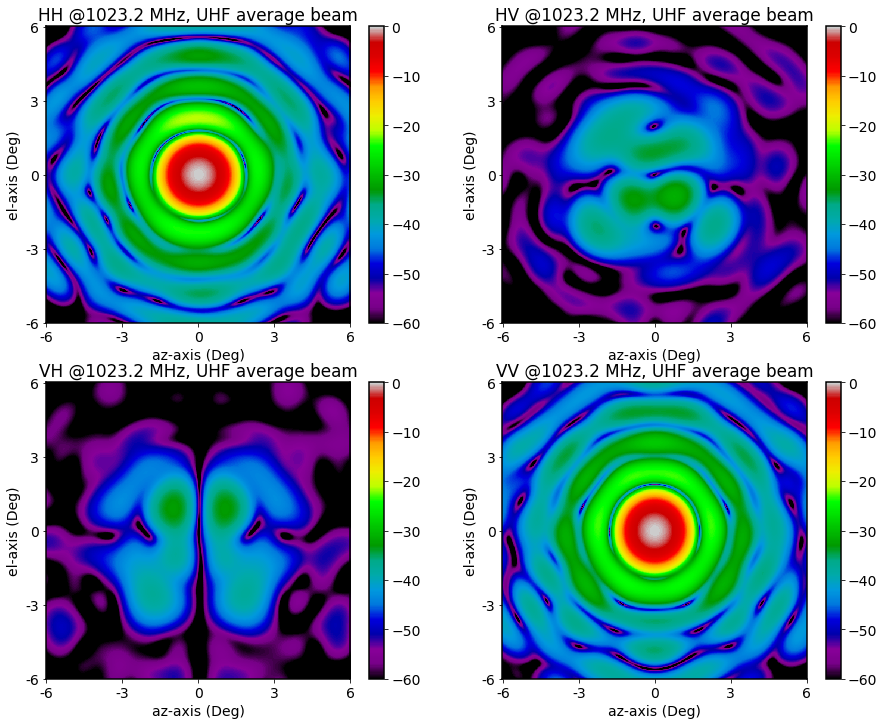

In [24]:
plt.figure(figsize = (15,12))
plt.subplot(221)
plt.imshow(10*np.log10(img_HH),cmap='spectral',aspect='auto')
plt.title('HH @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.clim(-60,0)
plt.colorbar()
plt.xticks(pix_ticks,['-6','-3','0','3','6'])
plt.yticks(pix_ticks,['6','3','0','-3','-6'])
plt.xlabel('az-axis (Deg)')
plt.ylabel('el-axis (Deg)')
plt.subplot(222)
plt.imshow(10*np.log10(img_HV),cmap='spectral',aspect='auto')
plt.title('HV @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.clim(-60,0)
plt.colorbar()
plt.xticks(pix_ticks,['-6','-3','0','3','6'])
plt.yticks(pix_ticks,['6','3','0','-3','-6'])
plt.xlabel('az-axis (Deg)')
plt.ylabel('el-axis (Deg)')
plt.subplot(223)
plt.imshow(10*np.log10(img_VH),cmap='spectral',aspect='auto')
plt.title('VH @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.clim(-60,0)
plt.colorbar()
plt.xticks(pix_ticks,['-6','-3','0','3','6'])
plt.yticks(pix_ticks,['6','3','0','-3','-6'])
plt.xlabel('az-axis (Deg)')
plt.ylabel('el-axis (Deg)')
plt.subplot(224)
plt.imshow(10*np.log10(img_VV),cmap='spectral',aspect='auto')
plt.title('VV @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.clim(-60,0)
plt.colorbar()
plt.xticks(pix_ticks,['-6','-3','0','3','6'])
plt.yticks(pix_ticks,['6','3','0','-3','-6'])
plt.xlabel('az-axis (Deg)')
plt.ylabel('el-axis (Deg)')
plt.show()

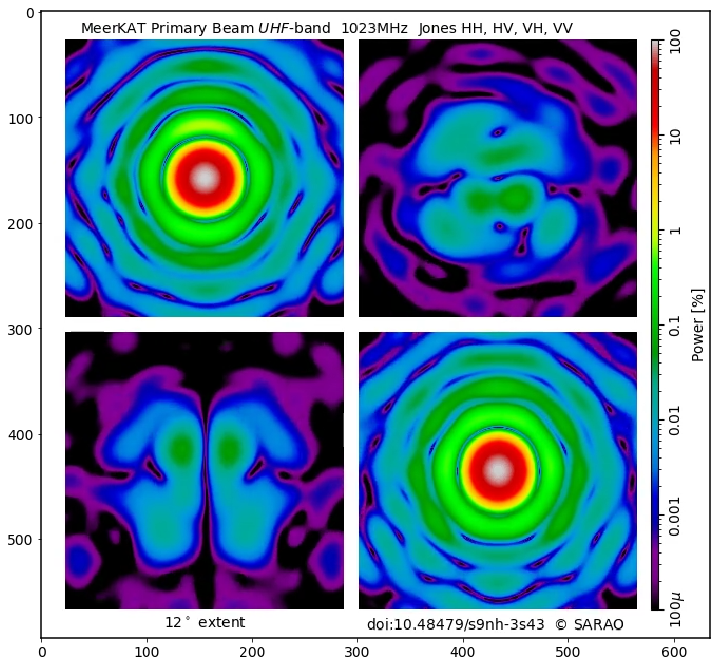

In [25]:
import matplotlib.image as mpimg
img = mpimg.imread('beam_ref.png')
plt.figure(figsize = (12,12))
imgplot = plt.imshow(img)
plt.show()

# $\textcolor{Red}{\text {\bf !!! pattern is [el,az], same to L-band}}$

In [26]:
cen_pix=int(Npix/2)
print (cen_pix)

256


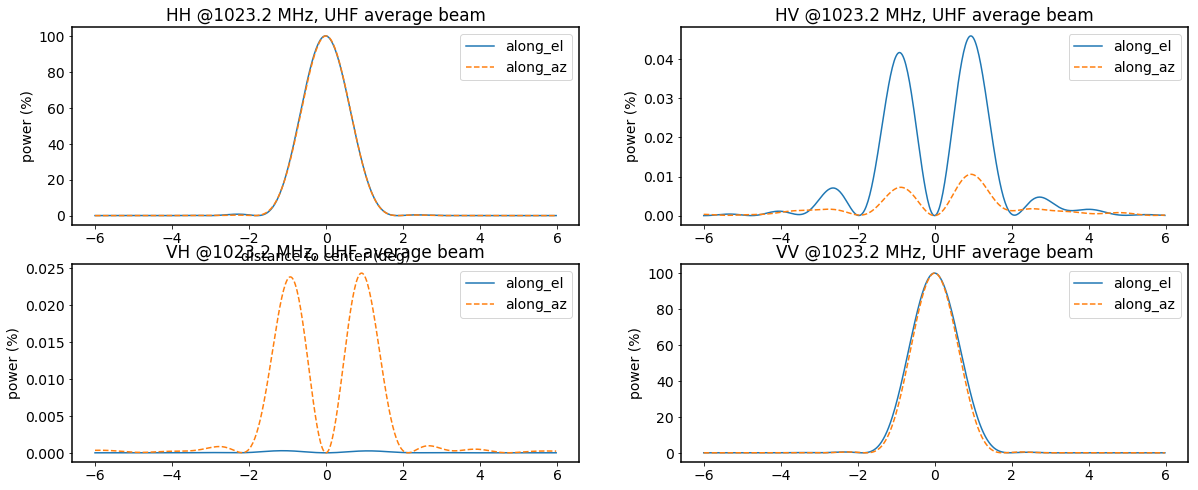

In [27]:
plt.figure(figsize=(20,8))
plt.subplot(221)
plt.plot(margin_deg, img_HH[:,cen_pix]*100)
plt.plot(margin_deg, img_HH[cen_pix,:]*100,'--')
plt.legend(['along_el','along_az'])
plt.xlabel('distance to center (deg)')
plt.ylabel('power (%)')
plt.title('HH @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.subplot(222)
plt.plot(margin_deg, img_HV[:,cen_pix]*100)
plt.plot(margin_deg, img_HV[cen_pix,:]*100,'--')
plt.legend(['along_el','along_az'])
plt.ylabel('power (%)')
plt.title('HV @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.subplot(223)
plt.plot(margin_deg, img_VH[:,cen_pix]*100)
plt.plot(margin_deg, img_VH[cen_pix,:]*100,'--')
plt.legend(['along_el','along_az'])
plt.ylabel('power (%)')
plt.title('VH @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.subplot(224)
plt.plot(margin_deg, img_VV[:,cen_pix]*100)
plt.plot(margin_deg, img_VV[cen_pix,:]*100,'--')
plt.legend(['along_el','along_az'])
plt.ylabel('power (%)')
plt.title('VV @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.show()

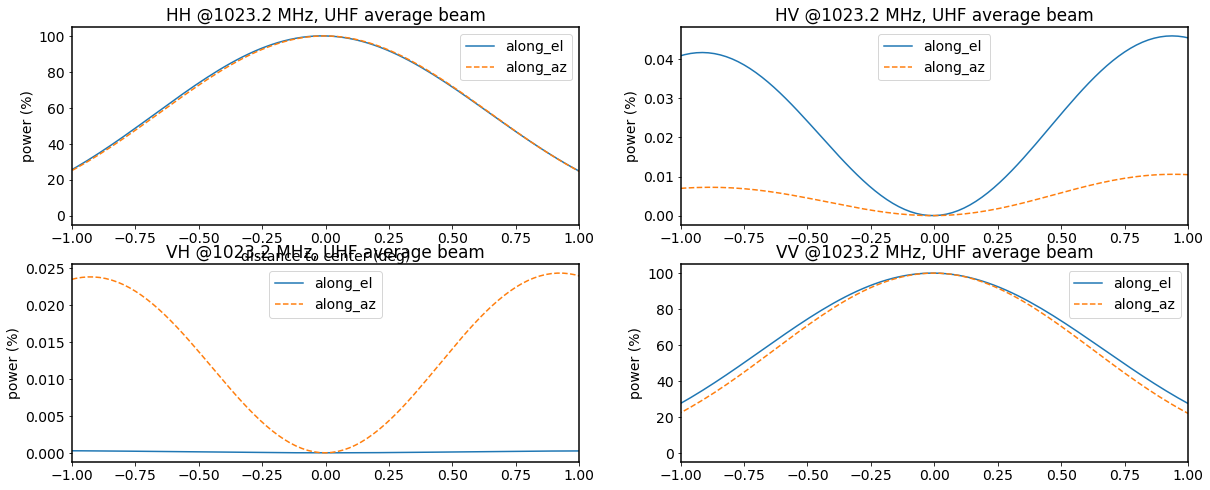

In [28]:
plt.figure(figsize=(20,8))
plt.subplot(221)
plt.plot(margin_deg, img_HH[:,cen_pix]*100)
plt.plot(margin_deg, img_HH[cen_pix,:]*100,'--')
plt.xlim(-1,1)
plt.legend(['along_el','along_az'])
plt.xlabel('distance to center (deg)')
plt.ylabel('power (%)')
plt.title('HH @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.subplot(222)
plt.plot(margin_deg, img_HV[:,cen_pix]*100)
plt.plot(margin_deg, img_HV[cen_pix,:]*100,'--')
plt.xlim(-1,1)
plt.legend(['along_el','along_az'])
plt.ylabel('power (%)')
plt.title('HV @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.subplot(223)
plt.plot(margin_deg, img_VH[:,cen_pix]*100)
plt.plot(margin_deg, img_VH[cen_pix,:]*100,'--')
plt.xlim(-1,1)
plt.legend(['along_el','along_az'])
plt.ylabel('power (%)')
plt.title('VH @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.subplot(224)
plt.plot(margin_deg, img_VV[:,cen_pix]*100)
plt.plot(margin_deg, img_VV[cen_pix,:]*100,'--')
plt.xlim(-1,1)
plt.legend(['along_el','along_az'])
plt.ylabel('power (%)')
plt.title('VV @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.show()

In [29]:
#end

In [30]:
Ddeg=12. #UHF

In [31]:
D_MeerKAT=13.5 #14.0 Khan preferred 14.0

In [32]:
freq0=freqs_MHz[grid_i]*1e6 #freq*1e6
sigma0=0.45*(3e8/freq0)/D_MeerKAT/np.pi*180.
print (sigma0)

sigma0_pix=sigma0/Ddeg*Npix

print (sigma0_pix)

0.55997341164823
23.892198896991147


In [33]:
r_cut=6.
pix_cut=r_cut/Ddeg*Npix
print (r_cut,pix_cut)

6.0 256.0


In [34]:
img=img_VV
center_x0=np.where(img[:,:]==img[:,:].max())[1][0]
center_y0=np.where(img[:,:]==img[:,:].max())[0][0]
print (center_x0,center_y0)
#print (np.std(img_VV))

256 256


In [35]:
#img=img_VV

In [36]:
xlist=[]
ylist=[]
zlist=[]
imgsize=img.shape[0]
img_cut=np.zeros([imgsize,imgsize])

for i in range(0, imgsize):
    for j in range(0, imgsize):
        r=np.sqrt((j-center_x0)**2+(i-center_y0)**2)
        x=float(j)
        y=float(i)
        if r<=pix_cut:
            img_cut[i,j]=img[i,j]
            
            xlist.append(x)
            ylist.append(y)
            zlist.append(img[i,j])
           

In [37]:
print (np.nanmean(zlist), np.nanstd(zlist)) 

0.019558623 0.09938275


In [38]:
z=np.array(zlist)
assert(z.max()==1)
Omega_A=(Ddeg/Npix/180.*np.pi)**2*z.sum()
light_speed = 2.99792485e8
#lbd = light_speed / (freqs[grid_i]*1e6)
lbd = light_speed / (freqs_MHz[grid_i]*1e6)
Aeff_max=lbd**2/Omega_A
print (Aeff_max)

127.42234383514013


In [39]:
Aeff_max

127.42234383514013

In [40]:
fit_result=opt.fmin_powell(func=func_obj, x0=[sigma0_pix,center_x0,center_y0], args=(np.array(xlist), np.array(ylist), np.array(zlist)),xtol=1e-10,ftol=1e-10)
sigma=fit_result[0]
sigma_deg=sigma/Npix*Ddeg
print (sigma_deg, sigma)
center_x1=fit_result[1]
center_y1=fit_result[2]

sig_factor=sigma0/sigma_deg
print (fit_result)
print (sig_factor,sig_factor**2)

Optimization terminated successfully.
         Current function value: 7.247524
         Iterations: 3
         Function evaluations: 198
0.595995508976265 25.429141716320636
[ 25.42914172 255.90408767 255.94385601]
0.9395597839488594 0.8827725876140274


In [41]:
model_value=np.zeros([imgsize,imgsize])
for i in range(0, imgsize):
    for j in range(0, imgsize):
        r=np.sqrt((j-center_x0)**2+(i-center_y0)**2)
        x=float(j)
        y=float(i)
        if r<=pix_cut:
            model_value[i,j]=gauss_model(x, y, center_x=center_x1,center_y=center_y1,sigma=sigma)

In [42]:
error=model_value-img_cut
print (error.mean(),error.min(),error.max())

0.00013980259937365456 -0.04794465911356377 0.033246430457942344


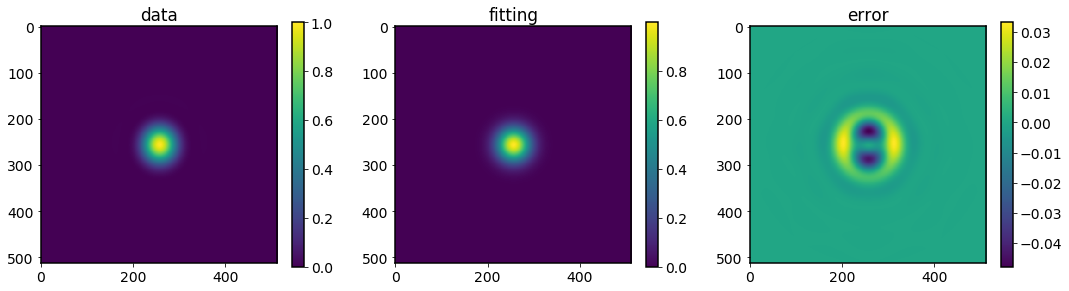

In [43]:

plt.figure(figsize = (18,4.5))
plt.subplot(131)
plt.imshow(img_cut)
plt.title('data')
plt.colorbar()
plt.subplot(132)
plt.imshow(model_value)
plt.title('fitting')
plt.colorbar()
plt.subplot(133)
plt.imshow(error)
plt.title('error')
plt.colorbar()
plt.show()

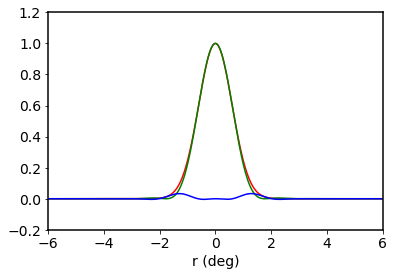

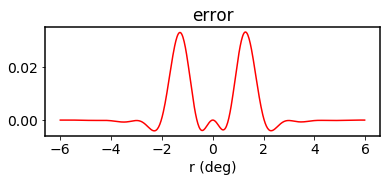

In [44]:
plt.figure(figsize=(6,4))
plt.plot((range(Npix)-center_y0)/float(Npix)*Ddeg,model_value[center_y0,:],'r')
plt.plot((range(Npix)-center_y0)/float(Npix)*Ddeg,img_cut[center_y0,:],'g')
plt.plot((range(Npix)-center_y0)/float(Npix)*Ddeg,model_value[center_y0,:]-img_cut[center_y0,:],'b')
plt.ylim(-0.2,1.2)
plt.xlim(-r_cut,r_cut)
plt.xlabel('r (deg)')
plt.show()
plt.figure(figsize=(6,2))
plt.plot((range(Npix)-center_y0)/float(Npix)*Ddeg,error[center_y0,:],'r-')
plt.title('error')
plt.xlabel('r (deg)')
plt.show()

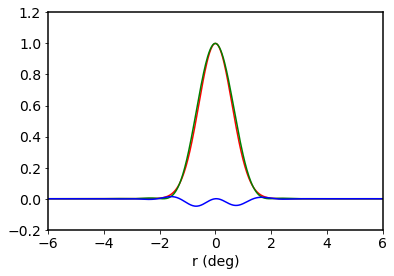

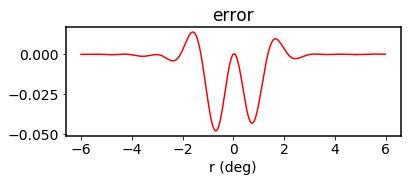

In [45]:
plt.figure(figsize=(6,4))
plt.plot((range(Npix)-center_x0)/float(Npix)*Ddeg,model_value[:,center_x0],'r')
plt.plot((range(Npix)-center_x0)/float(Npix)*Ddeg,img_cut[:,center_x0],'g')
plt.plot((range(Npix)-center_x0)/float(Npix)*Ddeg,model_value[:,center_x0]-img_cut[:,center_x0],'b')
plt.ylim(-0.2,1.2)
plt.xlim(-r_cut,r_cut)
plt.xlabel('r (deg)')
plt.show()
plt.figure(figsize=(6,2))
plt.plot((range(Npix)-center_x0)/float(Npix)*Ddeg,error[:,center_x0],'r-')
plt.title('error')
plt.xlabel('r (deg)')
plt.show()

In [46]:
#end

In [47]:
print ('end @ ' + time.asctime(time.localtime(time.time())) +'#')

end @ Thu Dec 26 16:00:33 2024#


# check the full band result

In [48]:
print ('start @ ' + time.asctime(time.localtime(time.time())) +'#')

start @ Thu Dec 26 16:00:33 2024#


In [49]:
file11='beam_HiRes_fit_data'#'beam_fit_data'
print (file11)
data1=pickle.load(open(file11,'rb'))


beam_HiRes_fit_data


In [50]:
data1.keys()

dict_keys(['grid_freq', 'sigma_HH', 'sigma_VV', 'Aeff_max_HH', 'Aeff_max_VV'])

In [51]:
grid_freq1=data1['grid_freq']
sigma1_HH=data1['sigma_HH']
sigma1_VV=data1['sigma_VV']
Aeff_max_HH=data1['Aeff_max_HH']
Aeff_max_VV=data1['Aeff_max_VV']
grid_freq1=np.array(grid_freq1)
sigma1_HH=np.array(sigma1_HH)
sigma1_VV=np.array(sigma1_VV)
Aeff_max_HH=np.array(Aeff_max_HH)
Aeff_max_VV=np.array(Aeff_max_VV)

In [52]:
print (grid_i, sigma1_HH[grid_i], sigma1_VV[grid_i])

902 0.597859105059831 0.595995508976265


In [53]:
print (len(grid_freq1),len(sigma1_HH),len(sigma1_VV))


1024 1024 1024


In [54]:
assert((grid_freq1==freqs_MHz).all())

In [55]:
D_MeerKAT1=13.5


In [56]:
freq1=grid_freq1*1e6
sigma0_1=np.degrees(0.45*(3e8/freq1)/D_MeerKAT1)


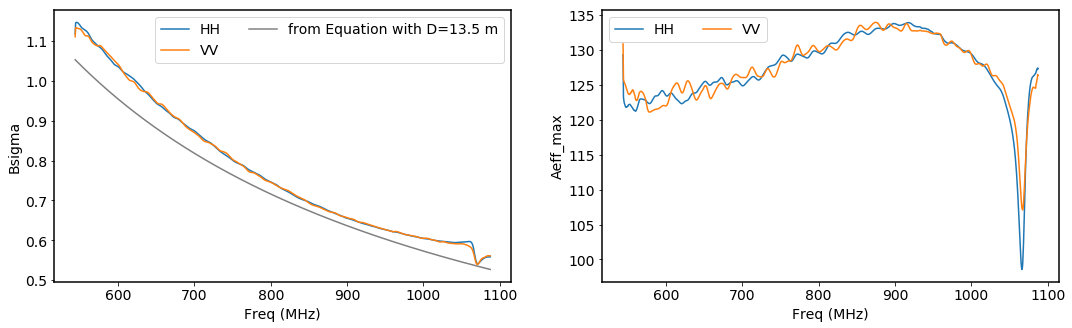

In [57]:
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(grid_freq1,sigma1_HH,'C0')
plt.plot(grid_freq1,sigma1_VV,'C1')
plt.plot(grid_freq1,sigma0_1,'grey')
plt.legend(['HH','VV', 'from Equation with D=13.5 m'], ncol=2)
plt.xlabel('Freq (MHz)')
plt.ylabel('Bsigma')
plt.subplot(122)
plt.plot(grid_freq1,Aeff_max_HH,'C0')
plt.plot(grid_freq1,Aeff_max_VV,'C1')
plt.legend(['HH','VV'], ncol=2)
plt.xlabel('Freq (MHz)')
plt.ylabel('Aeff_max')
plt.show()
plt.show()

In [58]:
for i in range(1024):
    j=4*i
    print (grid_freq1[i]-kio.cal_freq_UHF(j)/1e6,end=' ')

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

In [59]:
freqs_flist=np.array(kio.cal_freqs_UHF(range(4096)))/1e6
print (freqs_flist)

[ 544.         544.1328125  544.265625  ... 1087.6015625 1087.734375
 1087.8671875]


In [60]:
def rbf_spline(x_list1,y_list1,x_list2):
    rbf_func=Rbf(x_list1,y_list1)
    y_list2=rbf_func(x_list2)
    return y_list2

In [61]:
sigma_HH_full=rbf_spline(grid_freq1,sigma1_HH,freqs_flist)
sigma_VV_full=rbf_spline(grid_freq1,sigma1_VV,freqs_flist)
Aeff_max_HH_full=rbf_spline(grid_freq1,Aeff_max_HH,freqs_flist)
Aeff_max_VV_full=rbf_spline(grid_freq1,Aeff_max_VV,freqs_flist)

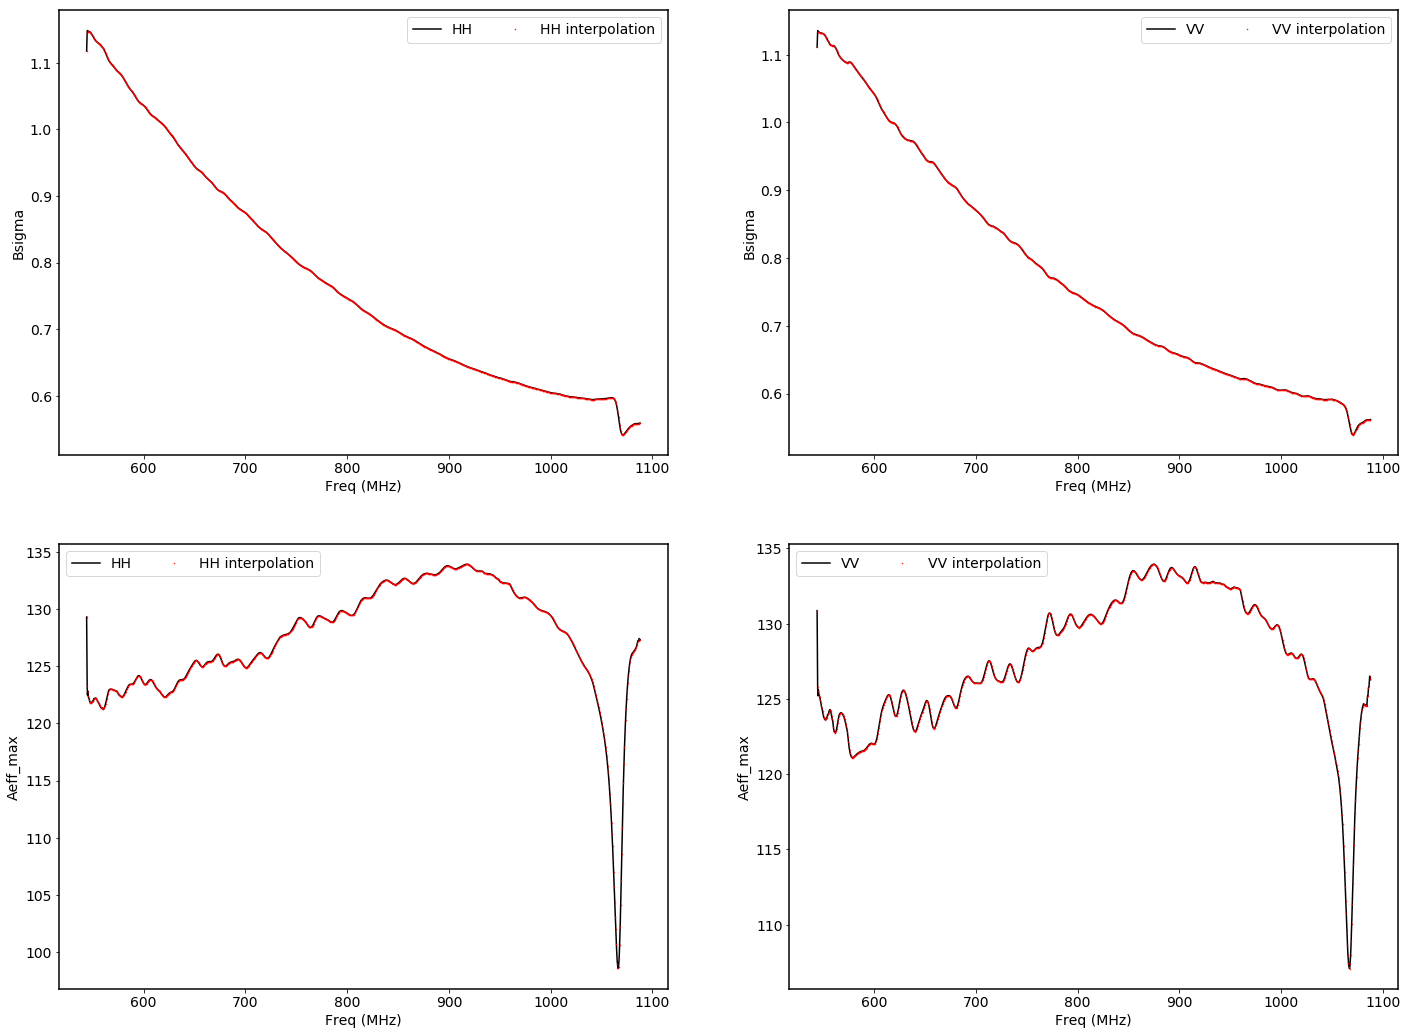

In [62]:
plt.figure(figsize=(24,18))
plt.subplot(221)
plt.plot(freqs_flist,sigma_HH_full,'k')
plt.plot(grid_freq1,sigma1_HH,'r.',ms=1)
plt.legend(['HH','HH interpolation'], ncol=2)
plt.xlabel('Freq (MHz)')
plt.ylabel('Bsigma')
plt.subplot(222)
plt.plot(freqs_flist,sigma_VV_full,'k')
plt.plot(grid_freq1,sigma1_VV,'r.',ms=1)
plt.legend(['VV', 'VV interpolation'], ncol=2)
plt.xlabel('Freq (MHz)')
plt.ylabel('Bsigma')
plt.subplot(223)
plt.plot(freqs_flist,Aeff_max_HH_full,'k')
plt.plot(grid_freq1,Aeff_max_HH,'r.',ms=1)
plt.legend(['HH','HH interpolation'], ncol=2)
plt.xlabel('Freq (MHz)')
plt.ylabel('Aeff_max')
plt.subplot(224)
plt.plot(freqs_flist,Aeff_max_VV_full,'k')
plt.plot(grid_freq1,Aeff_max_VV,'r.',ms=1)
plt.legend(['VV','VV interpolation'], ncol=2)
plt.xlabel('Freq (MHz)')
plt.ylabel('Aeff_max')
plt.show()

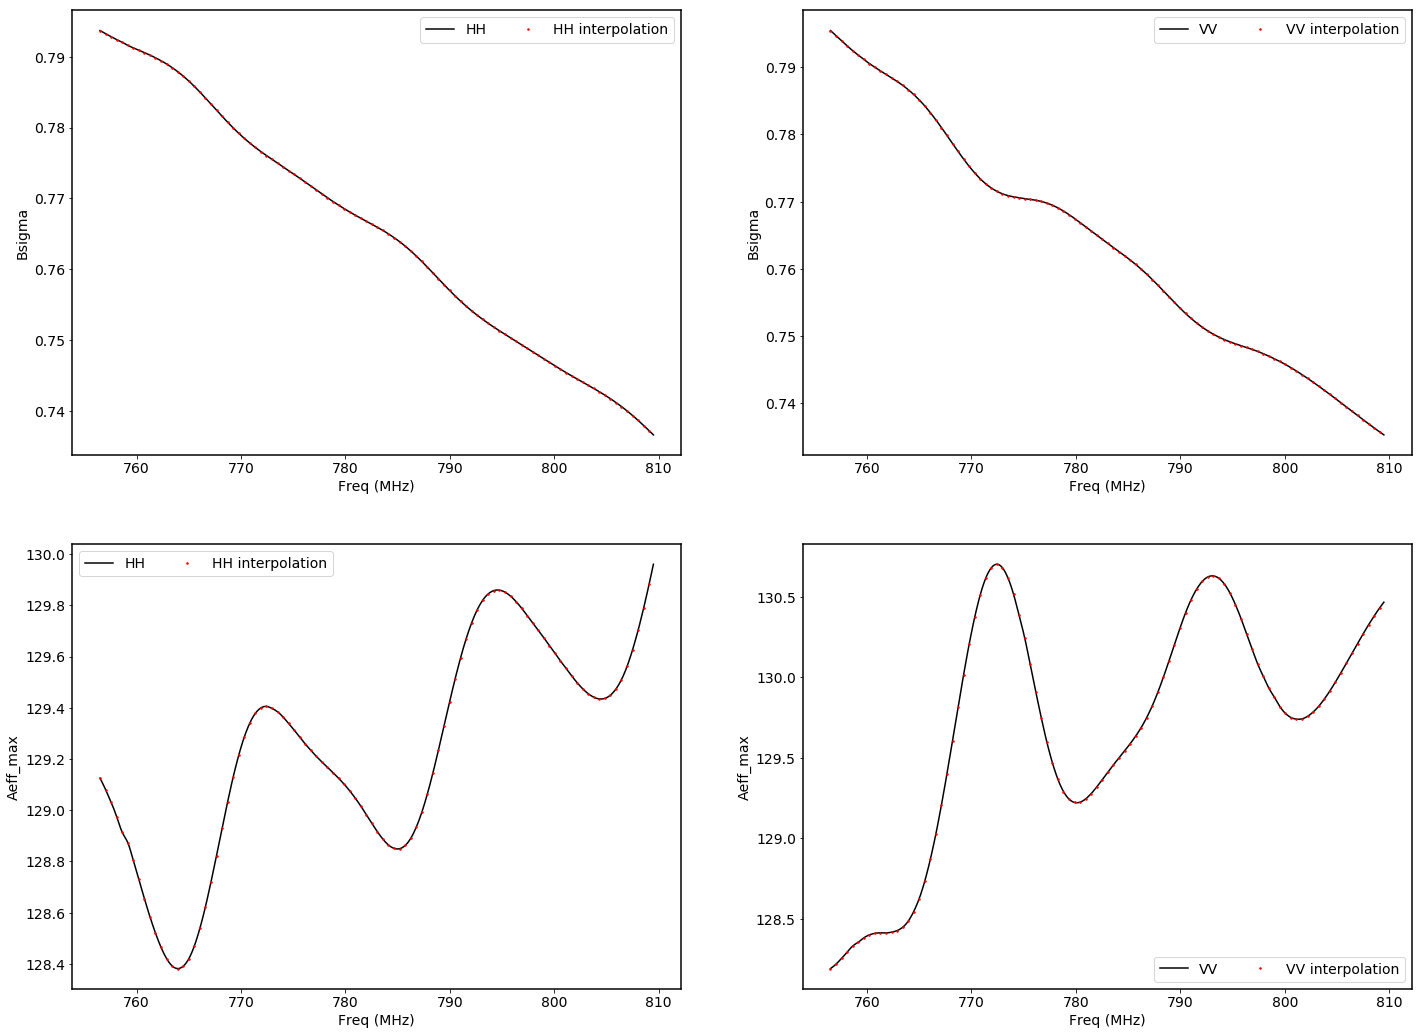

In [63]:
ch1,ch2=400,500
ch11,ch22=ch1*4,ch2*4
plt.figure(figsize=(24,18))
plt.subplot(221)
plt.plot(freqs_flist[ch11:ch22],sigma_HH_full[ch11:ch22],'k')
plt.plot(grid_freq1[ch1:ch2],sigma1_HH[ch1:ch2],'r.',ms=3)
plt.legend(['HH','HH interpolation'], ncol=2)
plt.xlabel('Freq (MHz)')
plt.ylabel('Bsigma')
plt.subplot(222)
plt.plot(freqs_flist[ch11:ch22],sigma_VV_full[ch11:ch22],'k')
plt.plot(grid_freq1[ch1:ch2],sigma1_VV[ch1:ch2],'r.',ms=3)
plt.legend(['VV', 'VV interpolation'], ncol=2)
plt.xlabel('Freq (MHz)')
plt.ylabel('Bsigma')
plt.subplot(223)
plt.plot(freqs_flist[ch11:ch22],Aeff_max_HH_full[ch11:ch22],'k')
plt.plot(grid_freq1[ch1:ch2],Aeff_max_HH[ch1:ch2],'r.',ms=3)
plt.legend(['HH','HH interpolation'], ncol=2)
plt.xlabel('Freq (MHz)')
plt.ylabel('Aeff_max')
plt.subplot(224)
plt.plot(freqs_flist[ch11:ch22],Aeff_max_VV_full[ch11:ch22],'k')
plt.plot(grid_freq1[ch1:ch2],Aeff_max_VV[ch1:ch2],'r.',ms=3)
plt.legend(['VV','VV interpolation'], ncol=2)
plt.xlabel('Freq (MHz)')
plt.ylabel('Aeff_max')
plt.show()

In [64]:
print (len(freqs_flist),len(sigma_HH_full),len(sigma_VV_full),len(Aeff_max_HH_full),len(Aeff_max_VV_full))

4096 4096 4096 4096 4096


In [65]:
data_p={}
data_p['freqs']=freqs_flist
data_p['sigma_HH']=sigma_HH_full
data_p['sigma_VV']=sigma_VV_full
data_p['Aeff_max_HH']=Aeff_max_HH_full
data_p['Aeff_max_VV']=Aeff_max_VV_full
fs=open('beam_HiRes_spline_data','wb')
pickle.dump(data_p,fs,protocol=2)
fs.close()


In [66]:
print ('end @ ' + time.asctime(time.localtime(time.time())) +'#')

end @ Thu Dec 26 16:00:38 2024#
